In [1]:
!python -V

Python 3.10.9


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [15]:
df = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,37.533333


In [16]:
len(df.columns)

20

In [17]:
df.duration.std()

46.44530513776499

In [18]:
cnt_before = len(df.index)
cnt_before

2463931

In [19]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_3104/1299758185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [20]:
cntafter = len(df.index)

In [22]:
cntafter

2421440

In [24]:
((cnt_before - cntafter ) / cnt_before ) * 100

1.7245206947759495

In [25]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.001496179434409

In [26]:
print(X_train.shape)

(2421440, 516)


/tmp/ipykernel_3104/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_3104/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


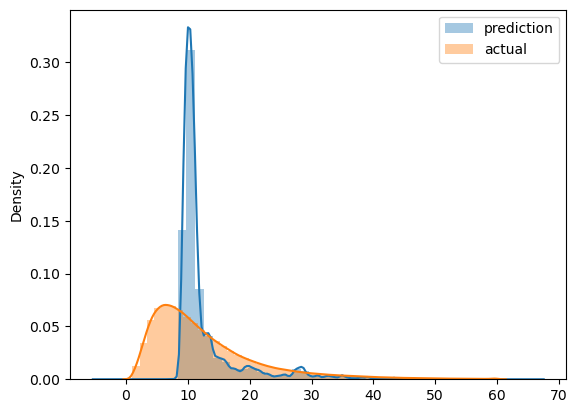

In [27]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [28]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [29]:
df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

In [17]:
len(df_train), len(df_val)

(2421440, 2918187)

In [18]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [19]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.530354906009318

In [22]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/lin_reg.bin'

In [ ]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)